In [5]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import *
import numpy as np
import pandas as pd
from pandas_datareader import data as web
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import statsmodels.api as sm
plt.rcParams['figure.dpi']=1200

Download Data from FRED - Industrial Production: Manufacturing: Nondurable Goods: Ice Cream and Frozen Dessert (NAICS = 31152)

In [6]:
data = pd.DataFrame(web.get_data_fred('IPN31152N',
                                      start='1975-01-01',
                                      end='2024-12-01'))

data.rename({'IPN31152N': 'ice'}, axis=1, inplace=True)

Plotting business and its ACF

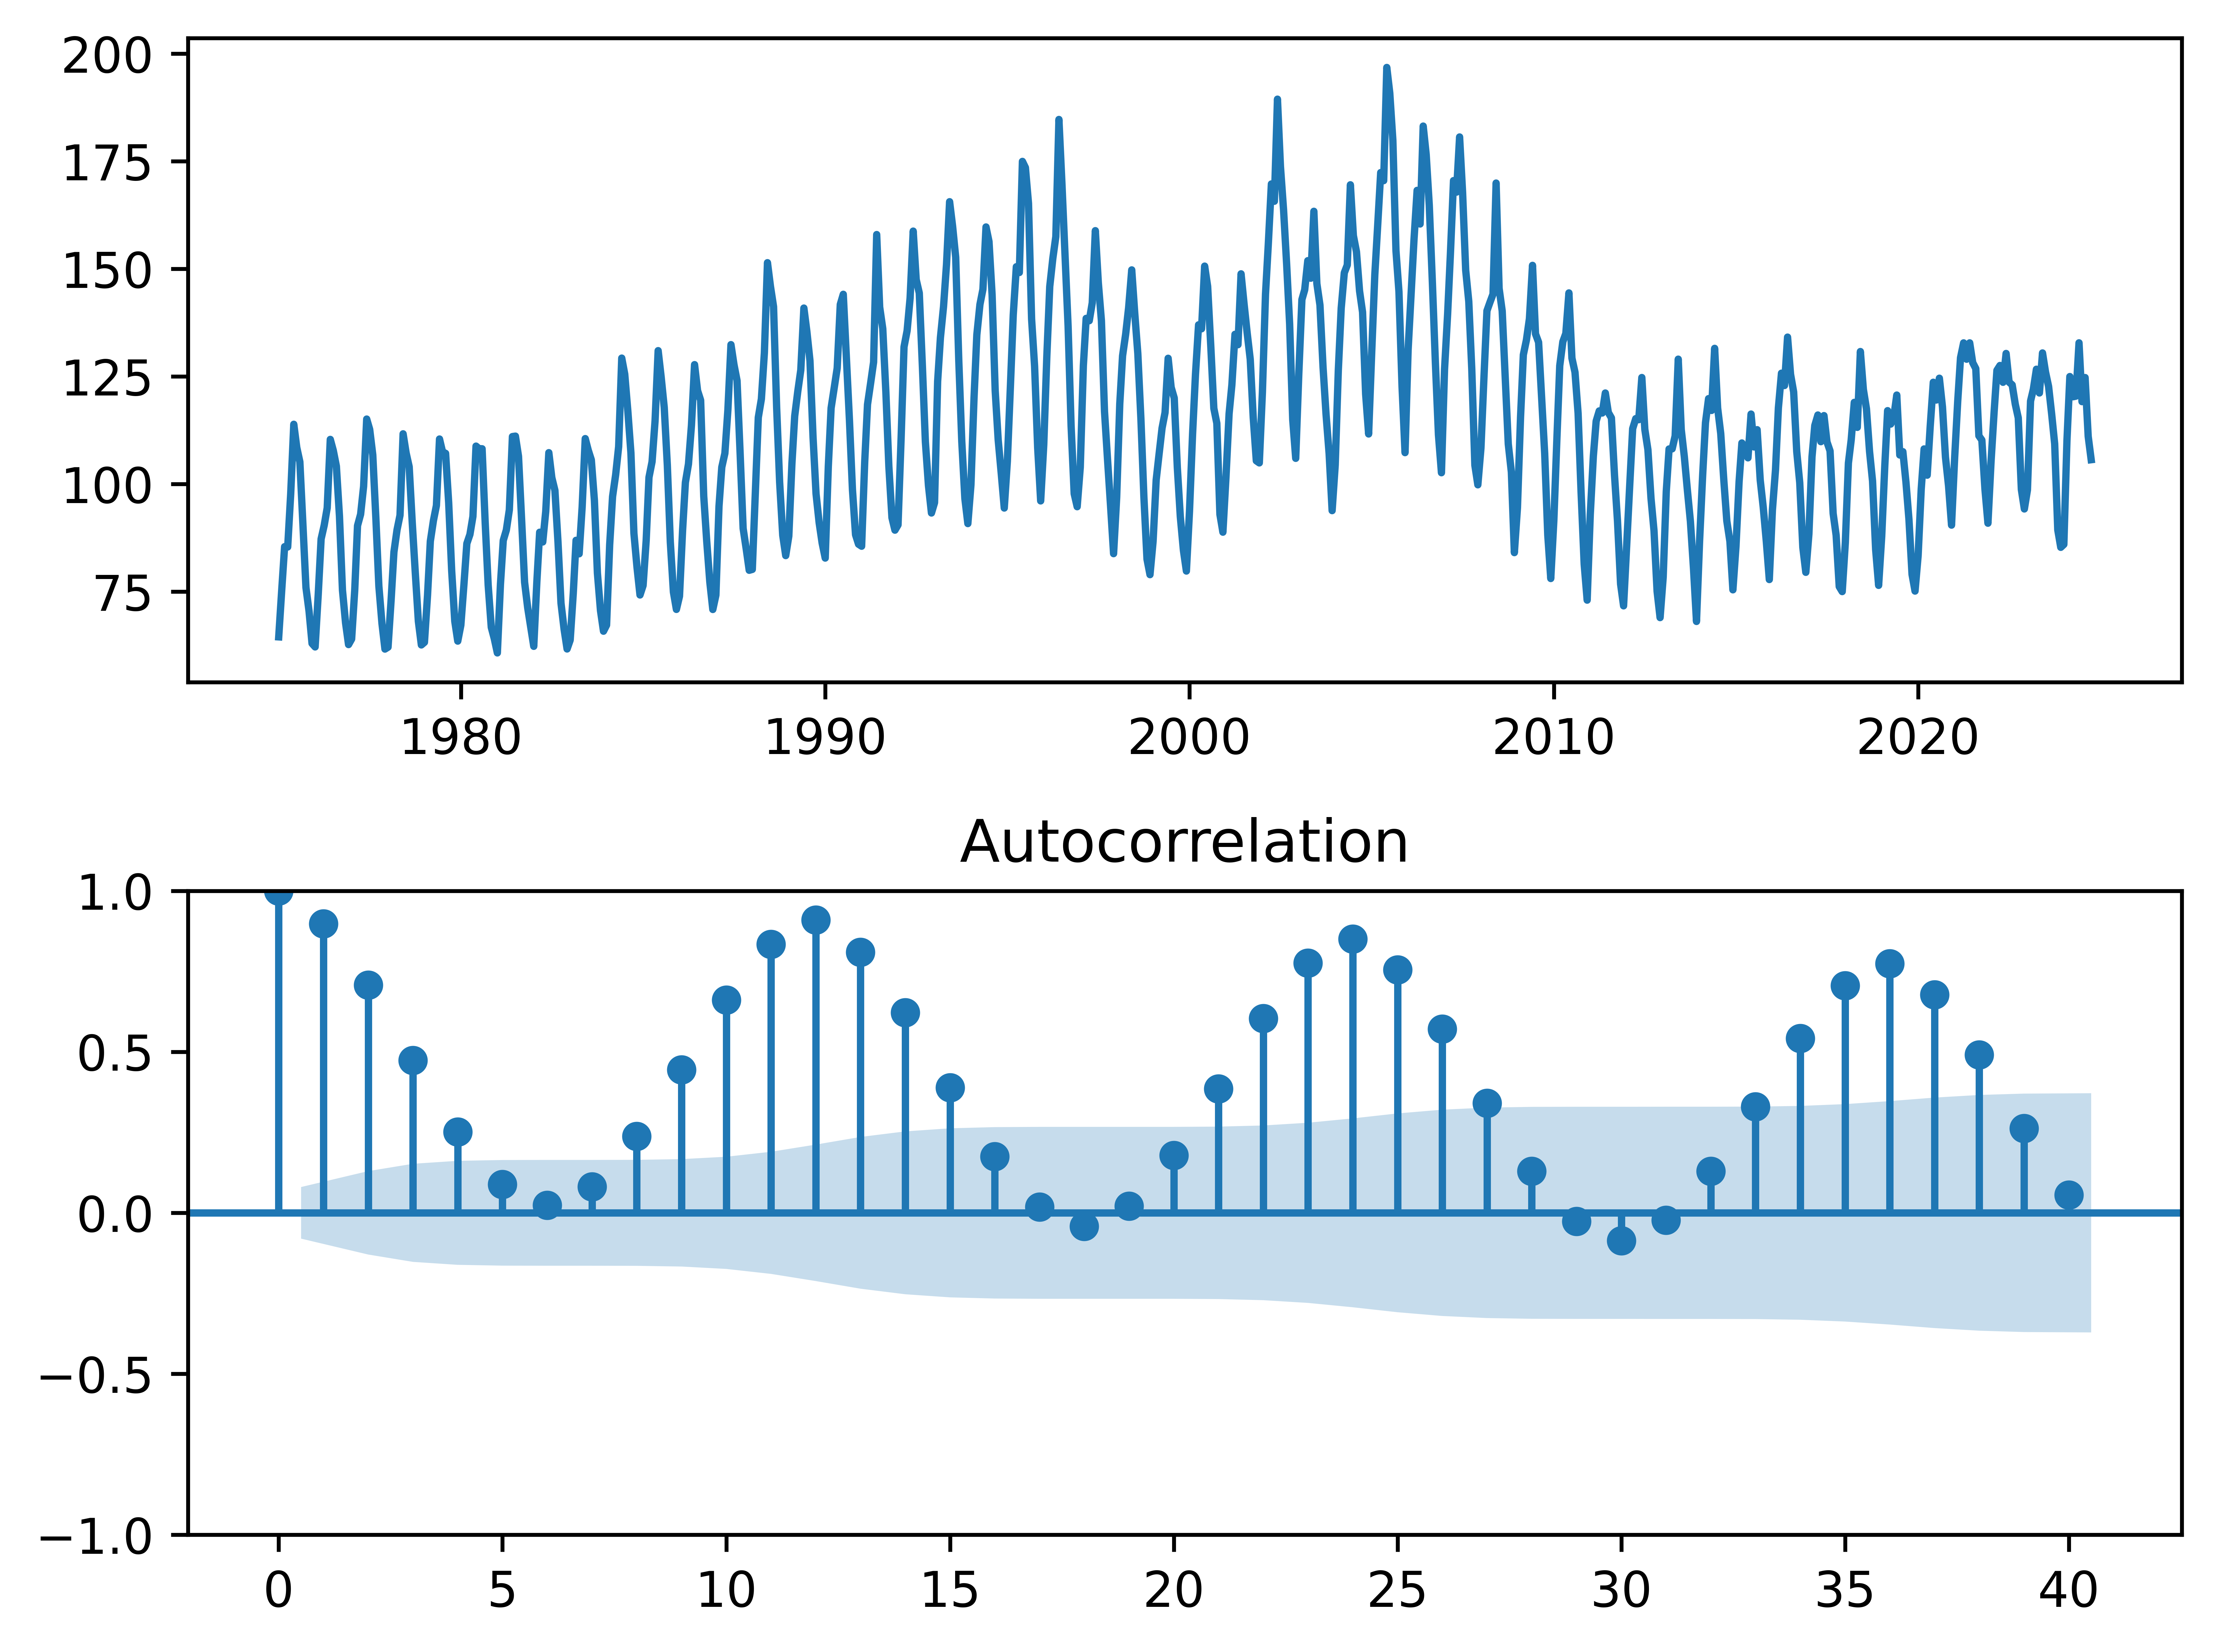

In [7]:
fig, axes = plt.subplots(2,1)
axes[0].plot(data.index, data['ice'])
sm.graphics.tsa.plot_acf(data['ice'], lags=40, ax=axes[1])
plt.tight_layout()
plt.show()

### **Top Panel: The Time Series Plot**

- The series shows a **clear seasonal pattern**
- There is also evidence of a **long-term trend**:
  - The series increases until around the early 2000s, peaks, and then appears to decline slightly before stabilizing.
- The combination of seasonality and a long-term trend suggests that this is **non-stationary** data.


### **Bottom Panel: Autocorrelation Function (ACF)**
- The autocorrelations are very high at multiples of 12 lags (e.g., 12, 24, 36), indicating seasonal dependencies.
- Significant autocorrelation at lower lags (1–5) suggests short-term persistence in the series.
- The seasonal structure is evident in the repeating peaks at multiples of 12, consistent with annual seasonality for monthly data.
- The slow decay of the autocorrelations also supports the non-stationarity of the series.

# Convert Series to Monthly Frequency, AR Modeling

In [8]:
dep = data['ice'].asfreq('MS') # monthly start frequency, dep is dependent variable
T = len(data.index) # number of observations

Fit an AR(3) Model (No Seasonality)

$$
\text{ice}_t 
= \phi_{0} 
+ \phi_{1}\,\text{ice}_{t-1} 
+ \phi_{2}\,\text{ice}_{t-2} 
+ \phi_{3}\,\text{ice}_{t-3} 
+ \varepsilon_{t}.
$$




This specifies the number of lags to use in the HAC estimator. 

**maxlags** is calculated as:
$$
\text{maxlags} = \left\lfloor 0.75 \cdot T^{1/3} \right\rfloor,
$$
where \( T \) is the number of observations in the time series (len(dep)). This is a common rule of thumb for choosing the number of lags for HAC estimation.


In [9]:
modelAR3 = AutoReg(dep, lags=3)
resul_AR3 = modelAR3.fit(cov_type='HAC',
                         cov_kwds={'maxlags': int(0.75*T**(1/3))})

print(resul_AR3.summary())

                            AutoReg Model Results                             
Dep. Variable:                    ice   No. Observations:                  598
Model:                     AutoReg(3)   Log Likelihood               -2193.325
Method:               Conditional MLE   S.D. of innovations              9.654
Date:                Thu, 16 Jan 2025   AIC                           4396.651
Time:                        00:04:36   BIC                           4418.594
Sample:                    04-01-1975   HQIC                          4405.196
                         - 10-01-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.3492      1.698     11.986      0.000      17.022      23.677
ice.L1         1.2734      0.036     35.296      0.000       1.203       1.344
ice.L2        -0.2646      0.062     -4.251      0.0

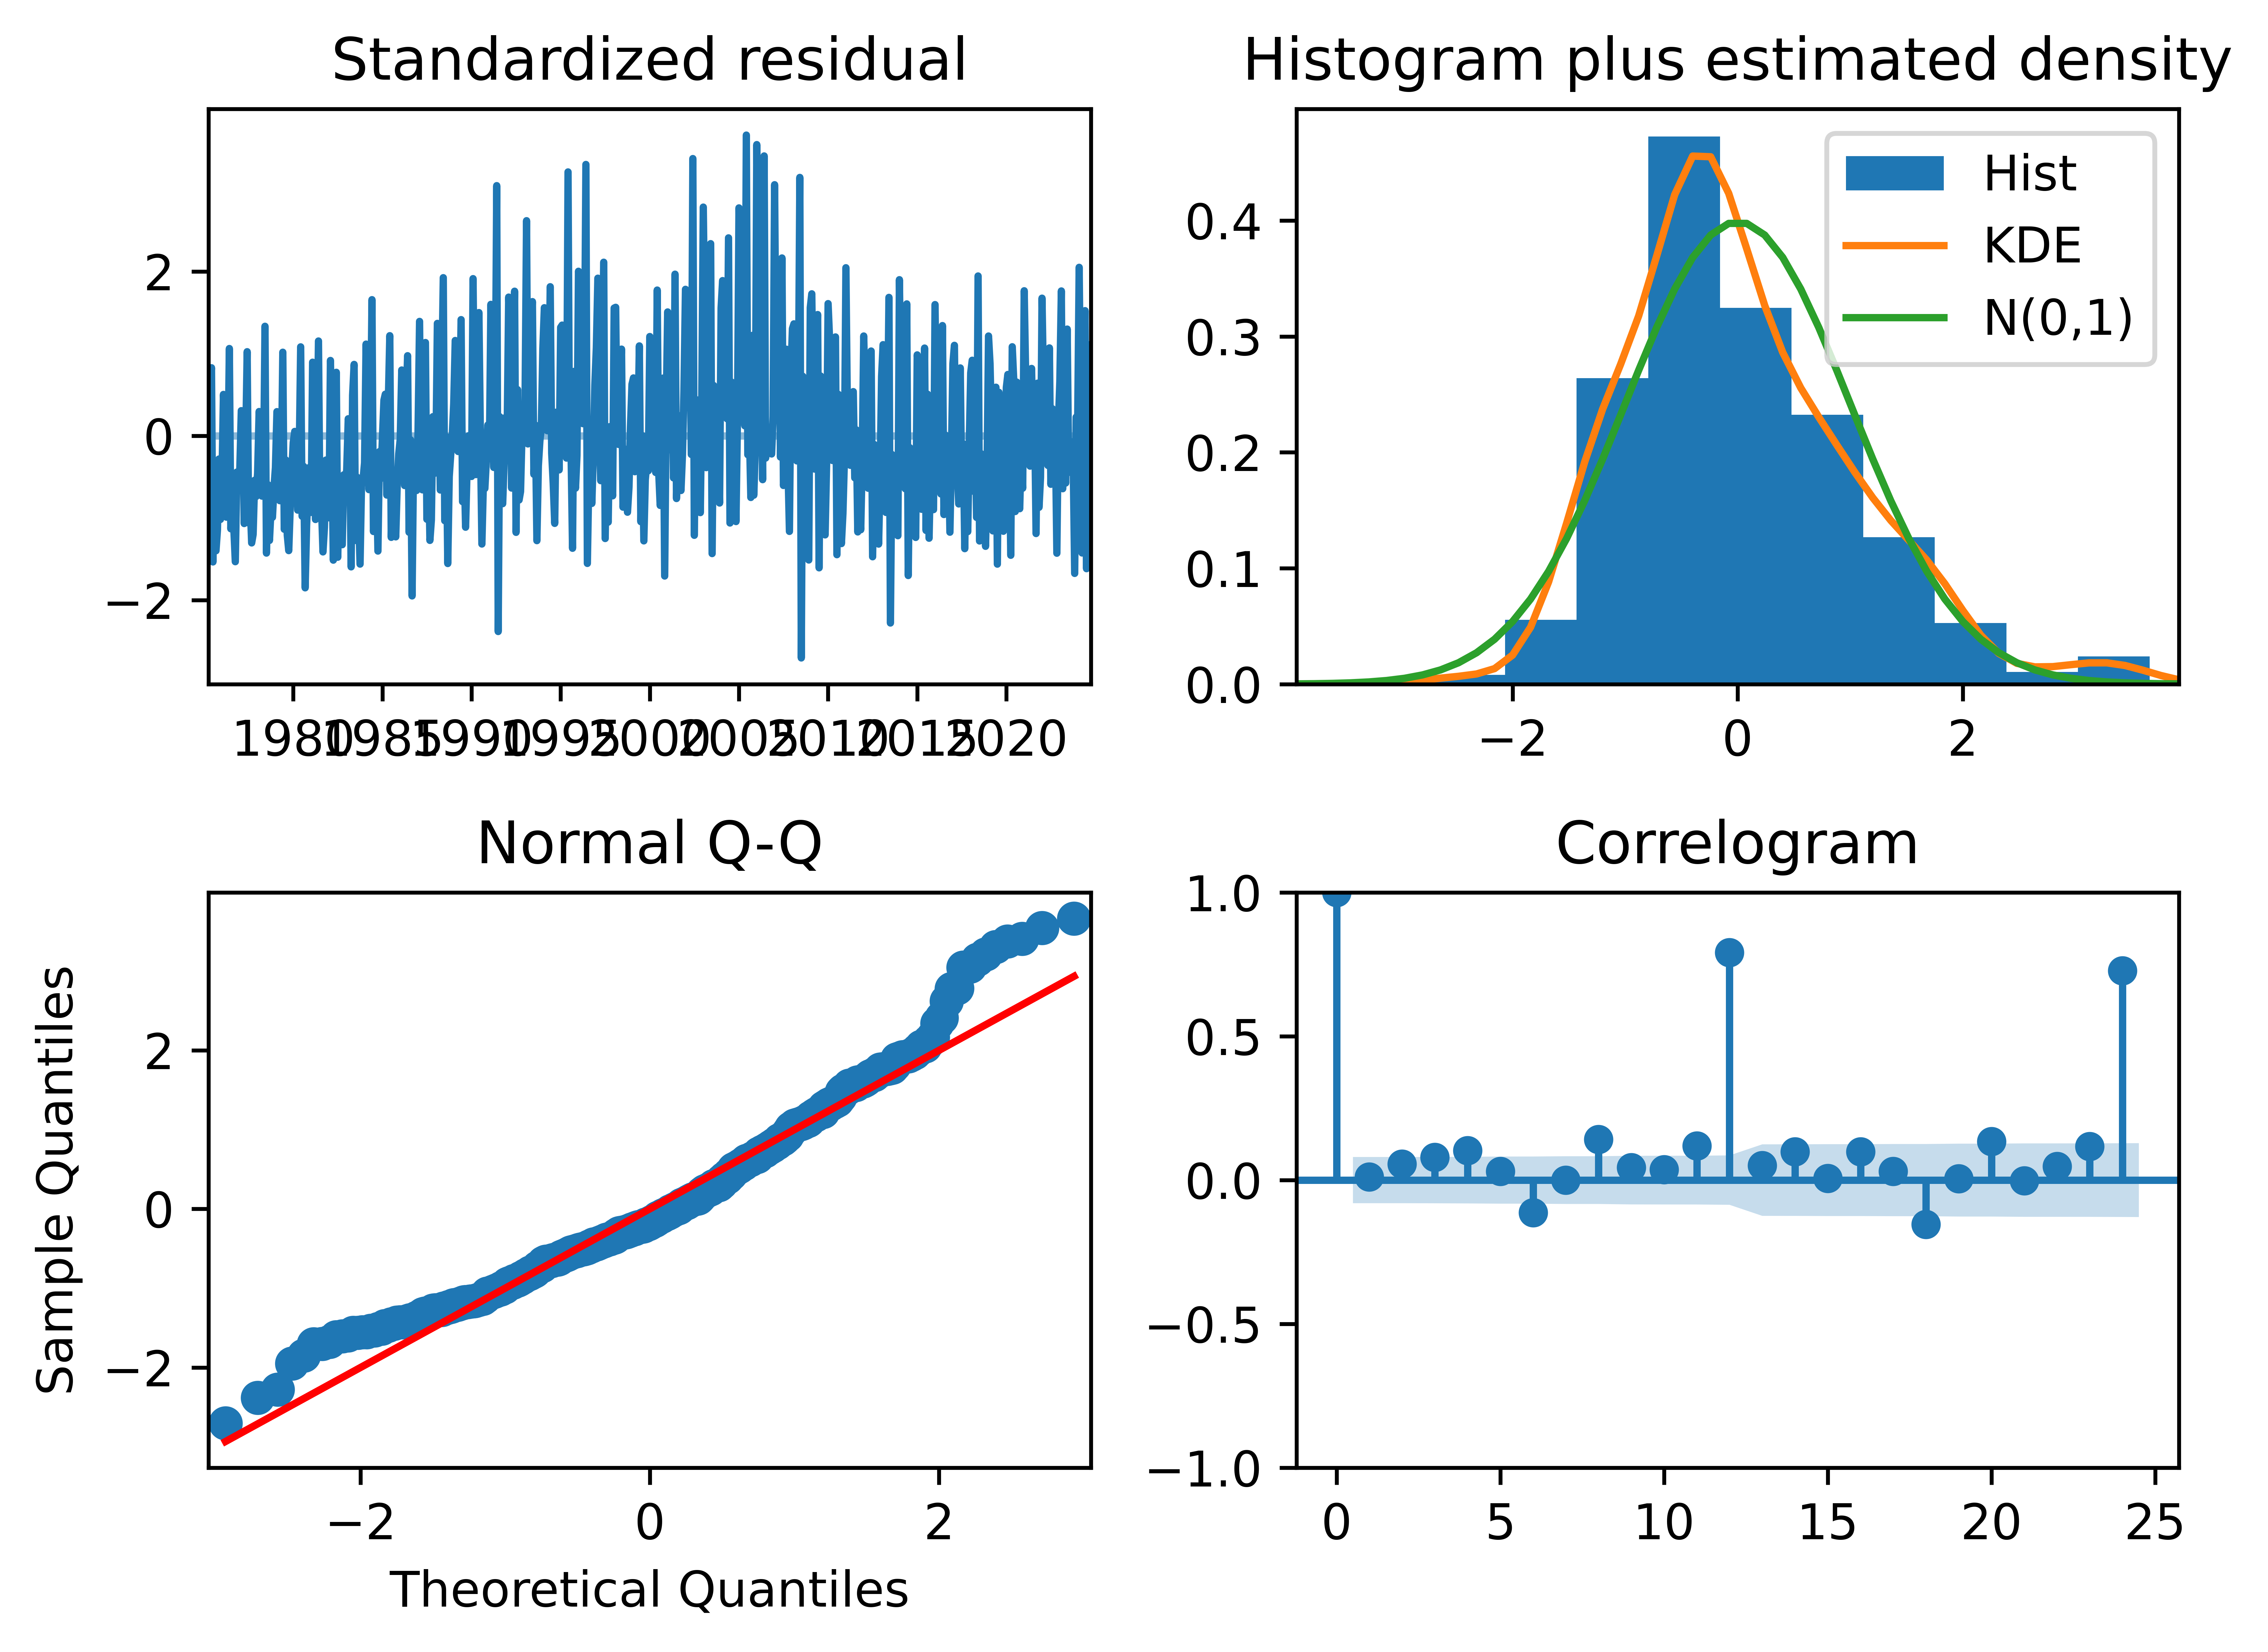

In [10]:
fig_diag = resul_AR3.plot_diagnostics(lags=24)
plt.tight_layout()
plt.show()

Fit a Seasonal AR(3) and AR(12) Model

In [11]:
modelAR3_S = AutoReg(dep, lags=3, seasonal=True, period=12)
results_AR3_S = modelAR3_S.fit(cov_type='HAC', 
                               cov_kwds={'maxlags': int(0.75*T**(1/3))})
print(results_AR3_S.summary())

                            AutoReg Model Results                             
Dep. Variable:                    ice   No. Observations:                  598
Model:               Seas. AutoReg(3)   Log Likelihood               -1801.833
Method:               Conditional MLE   S.D. of innovations              5.000
Date:                Thu, 16 Jan 2025   AIC                           3635.667
Time:                        00:04:42   BIC                           3705.884
Sample:                    04-01-1975   HQIC                          3663.011
                         - 10-01-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7069      1.567      6.831      0.000       7.635      13.779
s(2,12)        9.4072      1.332      7.064      0.000       6.797      12.017
s(3,12)        5.4208      1.718      3.155      0.0

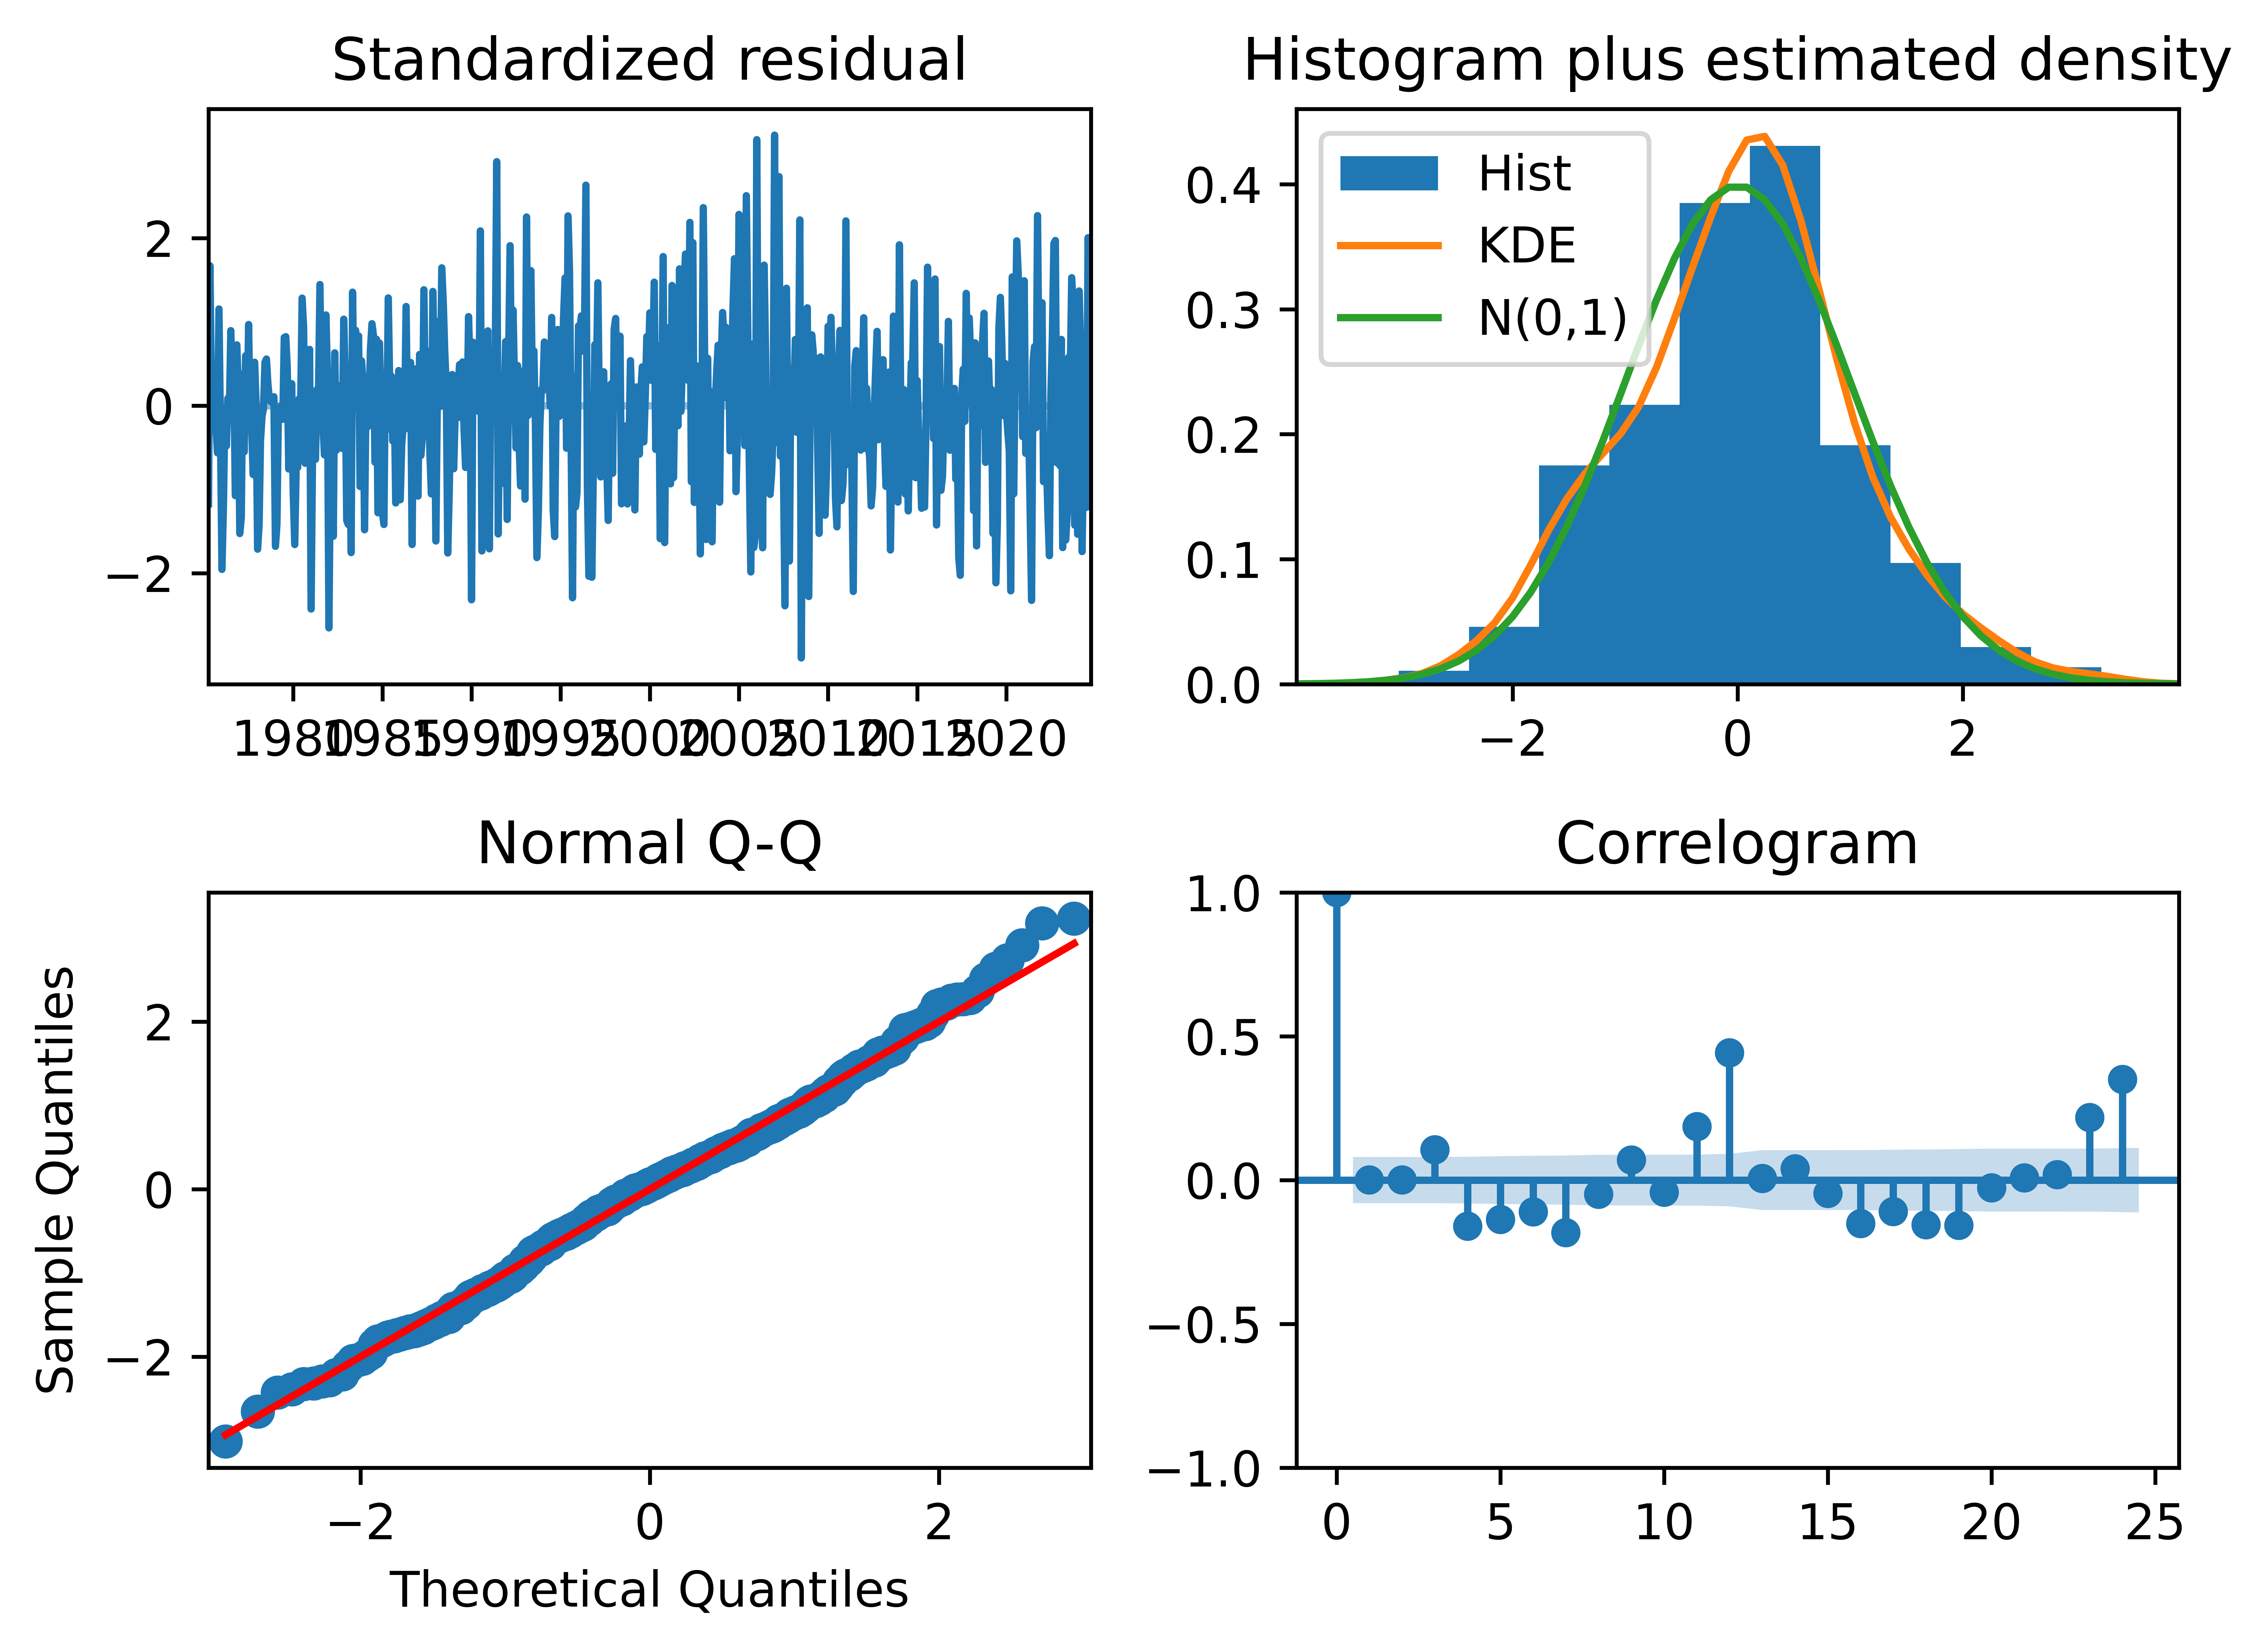

In [13]:
fig_diag = results_AR3_S.plot_diagnostics(lags=24)
plt.tight_layout()
plt.show()

Fit a Seasonal AR(3) and include seasonal lags for monthly data with a 12-month cycle.

                            AutoReg Model Results                             
Dep. Variable:                    ice   No. Observations:                  598
Model:              Seas. AutoReg(12)   Log Likelihood               -1731.323
Method:               Conditional MLE   S.D. of innovations              4.644
Date:                Wed, 15 Jan 2025   AIC                           3512.647
Time:                        21:56:06   BIC                           3621.980
Sample:                    01-01-1976   HQIC                          3555.253
                         - 10-01-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1646      1.886      3.798      0.000       3.467      10.862
s(2,12)        6.7538      1.619      4.172      0.000       3.581       9.927
s(3,12)        0.7603      1.788      0.425      0.6

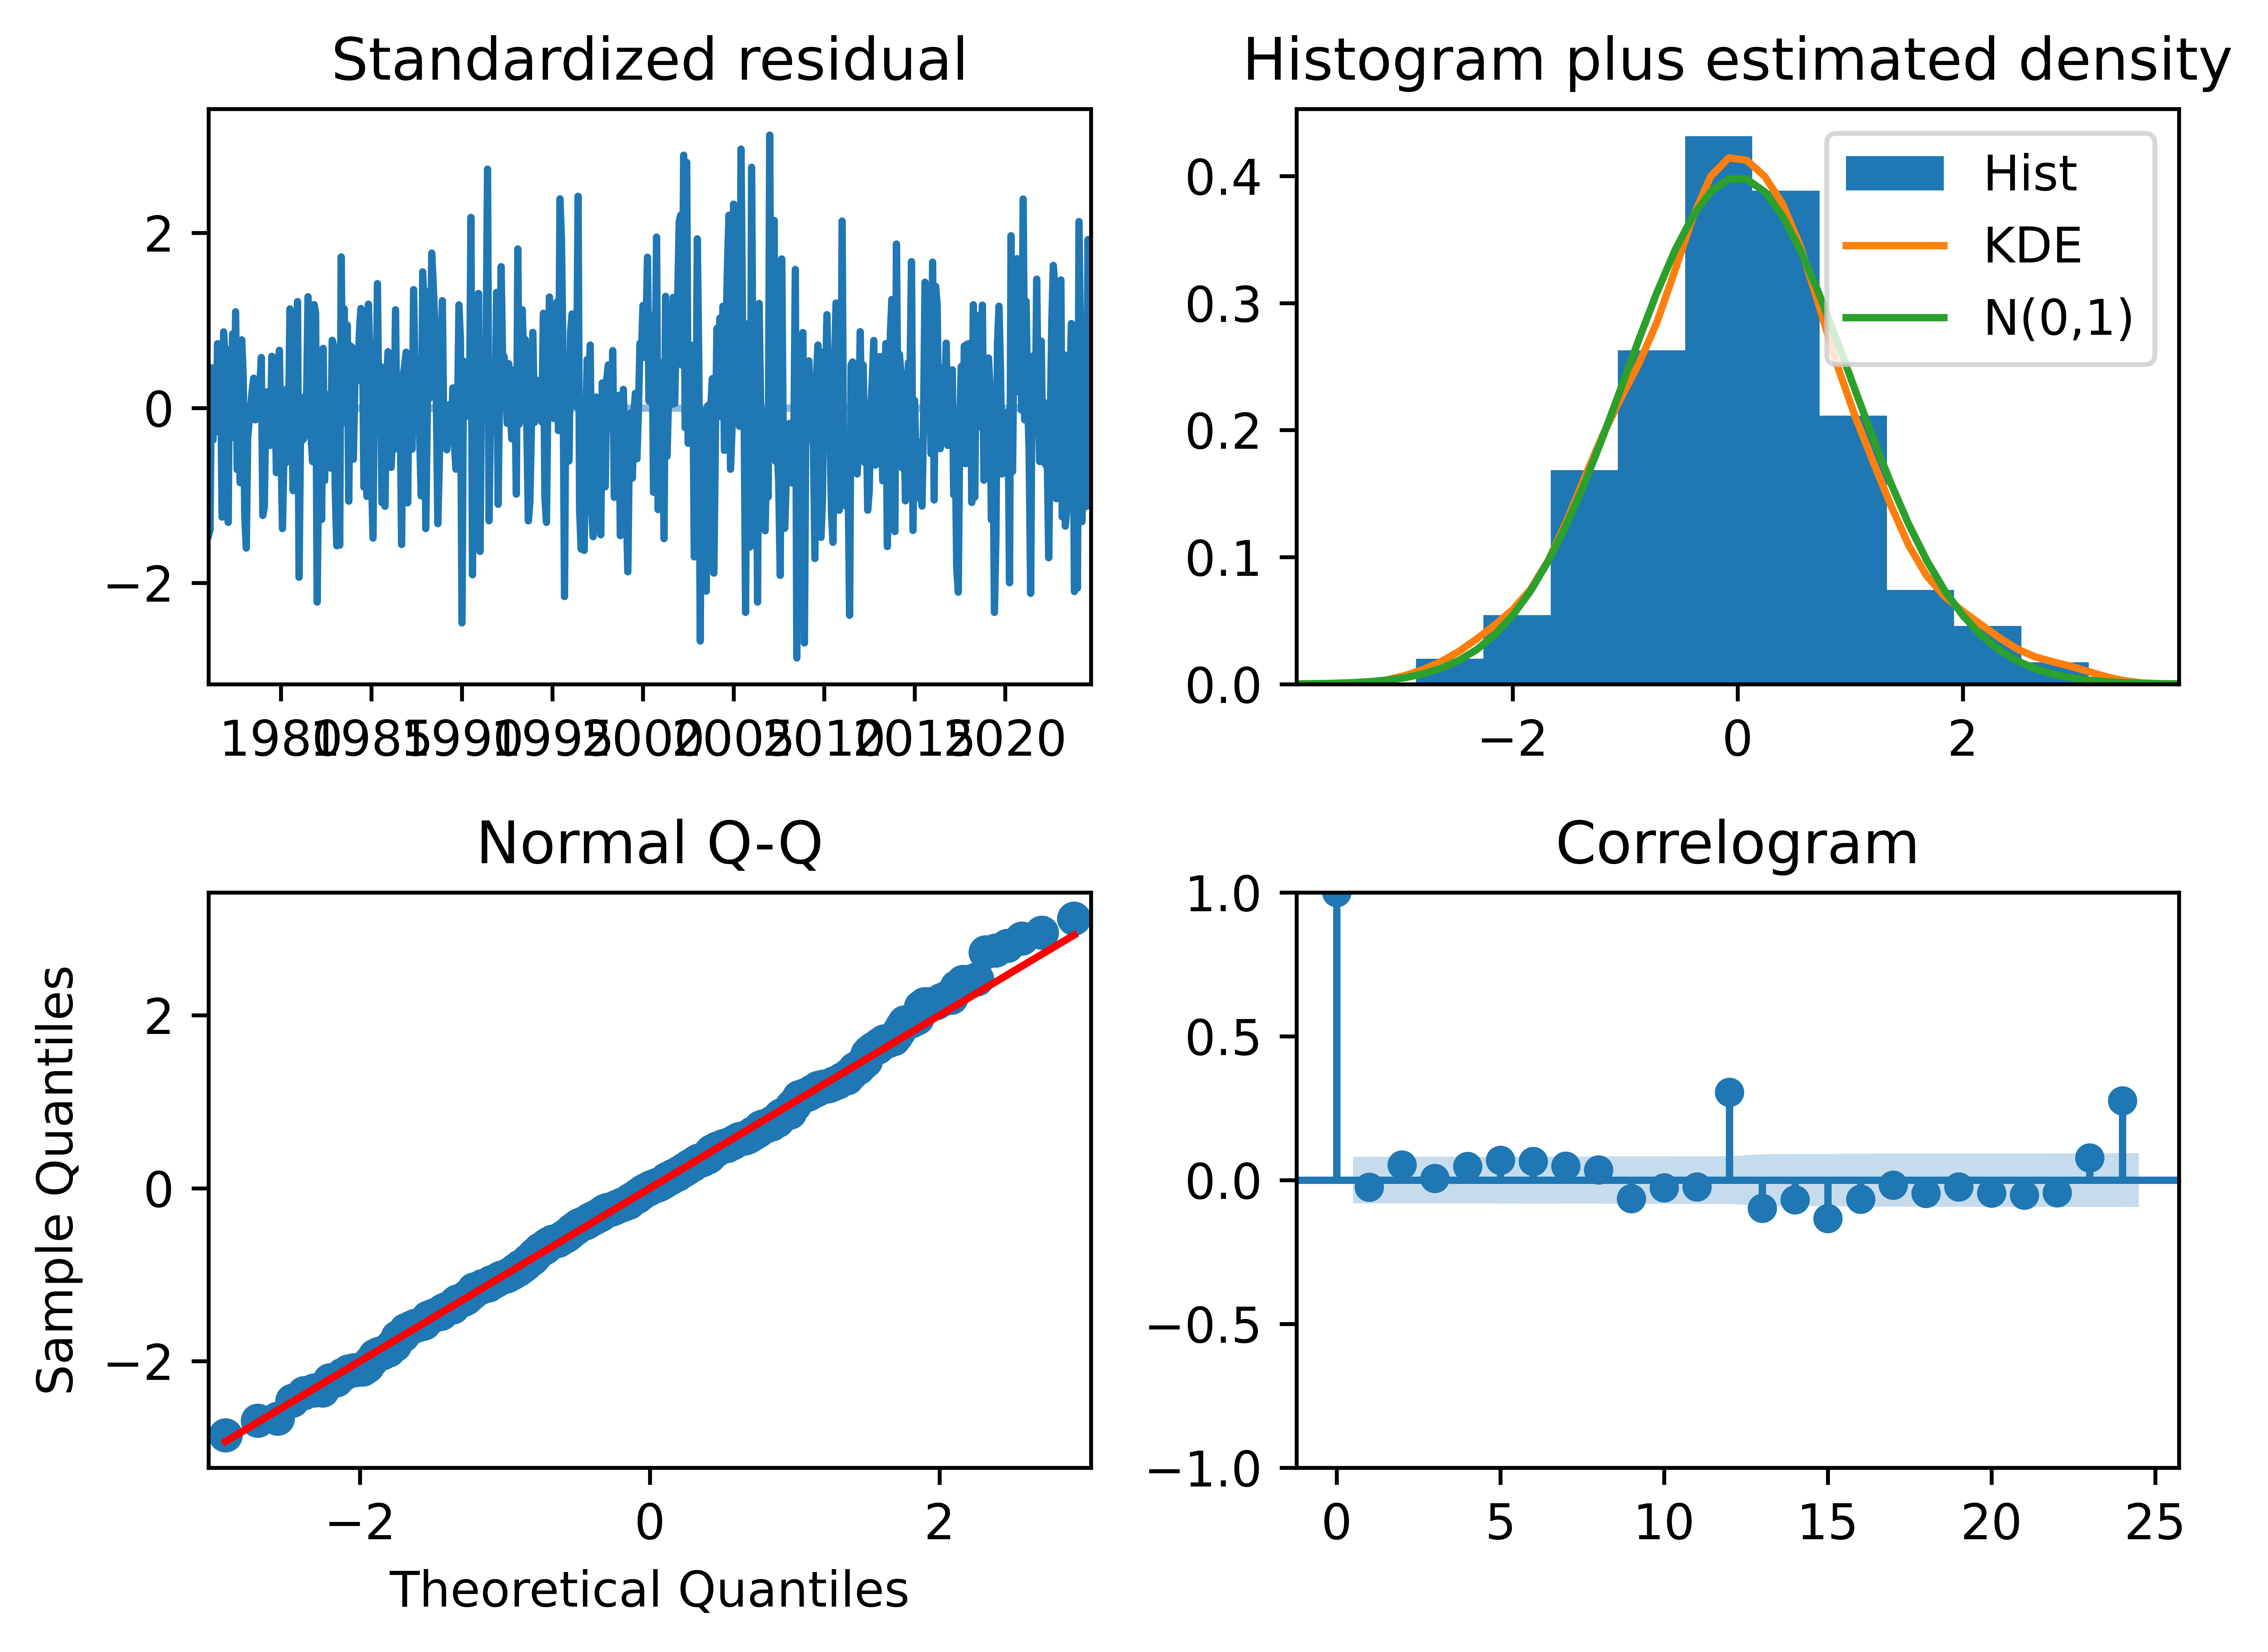

In [14]:
modelAR12_S = AutoReg(dep, lags=12, seasonal=True, period=12)
results_AR12_S = modelAR12_S.fit(cov_type='HAC',
                         cov_kwds={'maxlags': int(0.75*T**(1/3))})
print(results_AR12_S.summary())

fig_diag = results_AR12_S.plot_diagnostics(lags=24)
plt.tight_layout()
plt.show()

Model Selection

In [15]:
select_a_model = ar_select_order(dep, maxlag=30, ic='aic', glob=False, seasonal=True,
                                 period=12)
print(select_a_model.ar_lags)

results_selected_model = select_a_model.model.fit(cov_type='HAC',
                         cov_kwds={'maxlags': int(0.75*T**(1/3))})

print(results_selected_model.summary())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
                            AutoReg Model Results                             
Dep. Variable:                    ice   No. Observations:                  598
Model:              Seas. AutoReg(27)   Log Likelihood               -1604.865
Method:               Conditional MLE   S.D. of innovations              4.022
Date:                Thu, 16 Jan 2025   AIC                           3289.730
Time:                        00:17:48   BIC                           3463.625
Sample:                    04-01-1977   HQIC                          3357.573
                         - 10-01-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1015      1.721      0.640      0.522      -2.272       4.475
s(2,12)        4.0256      1.76

ar_select_order systematically tries AR models up to maxlag=30, using AIC (Akaike Information Criterion) to pick the best.

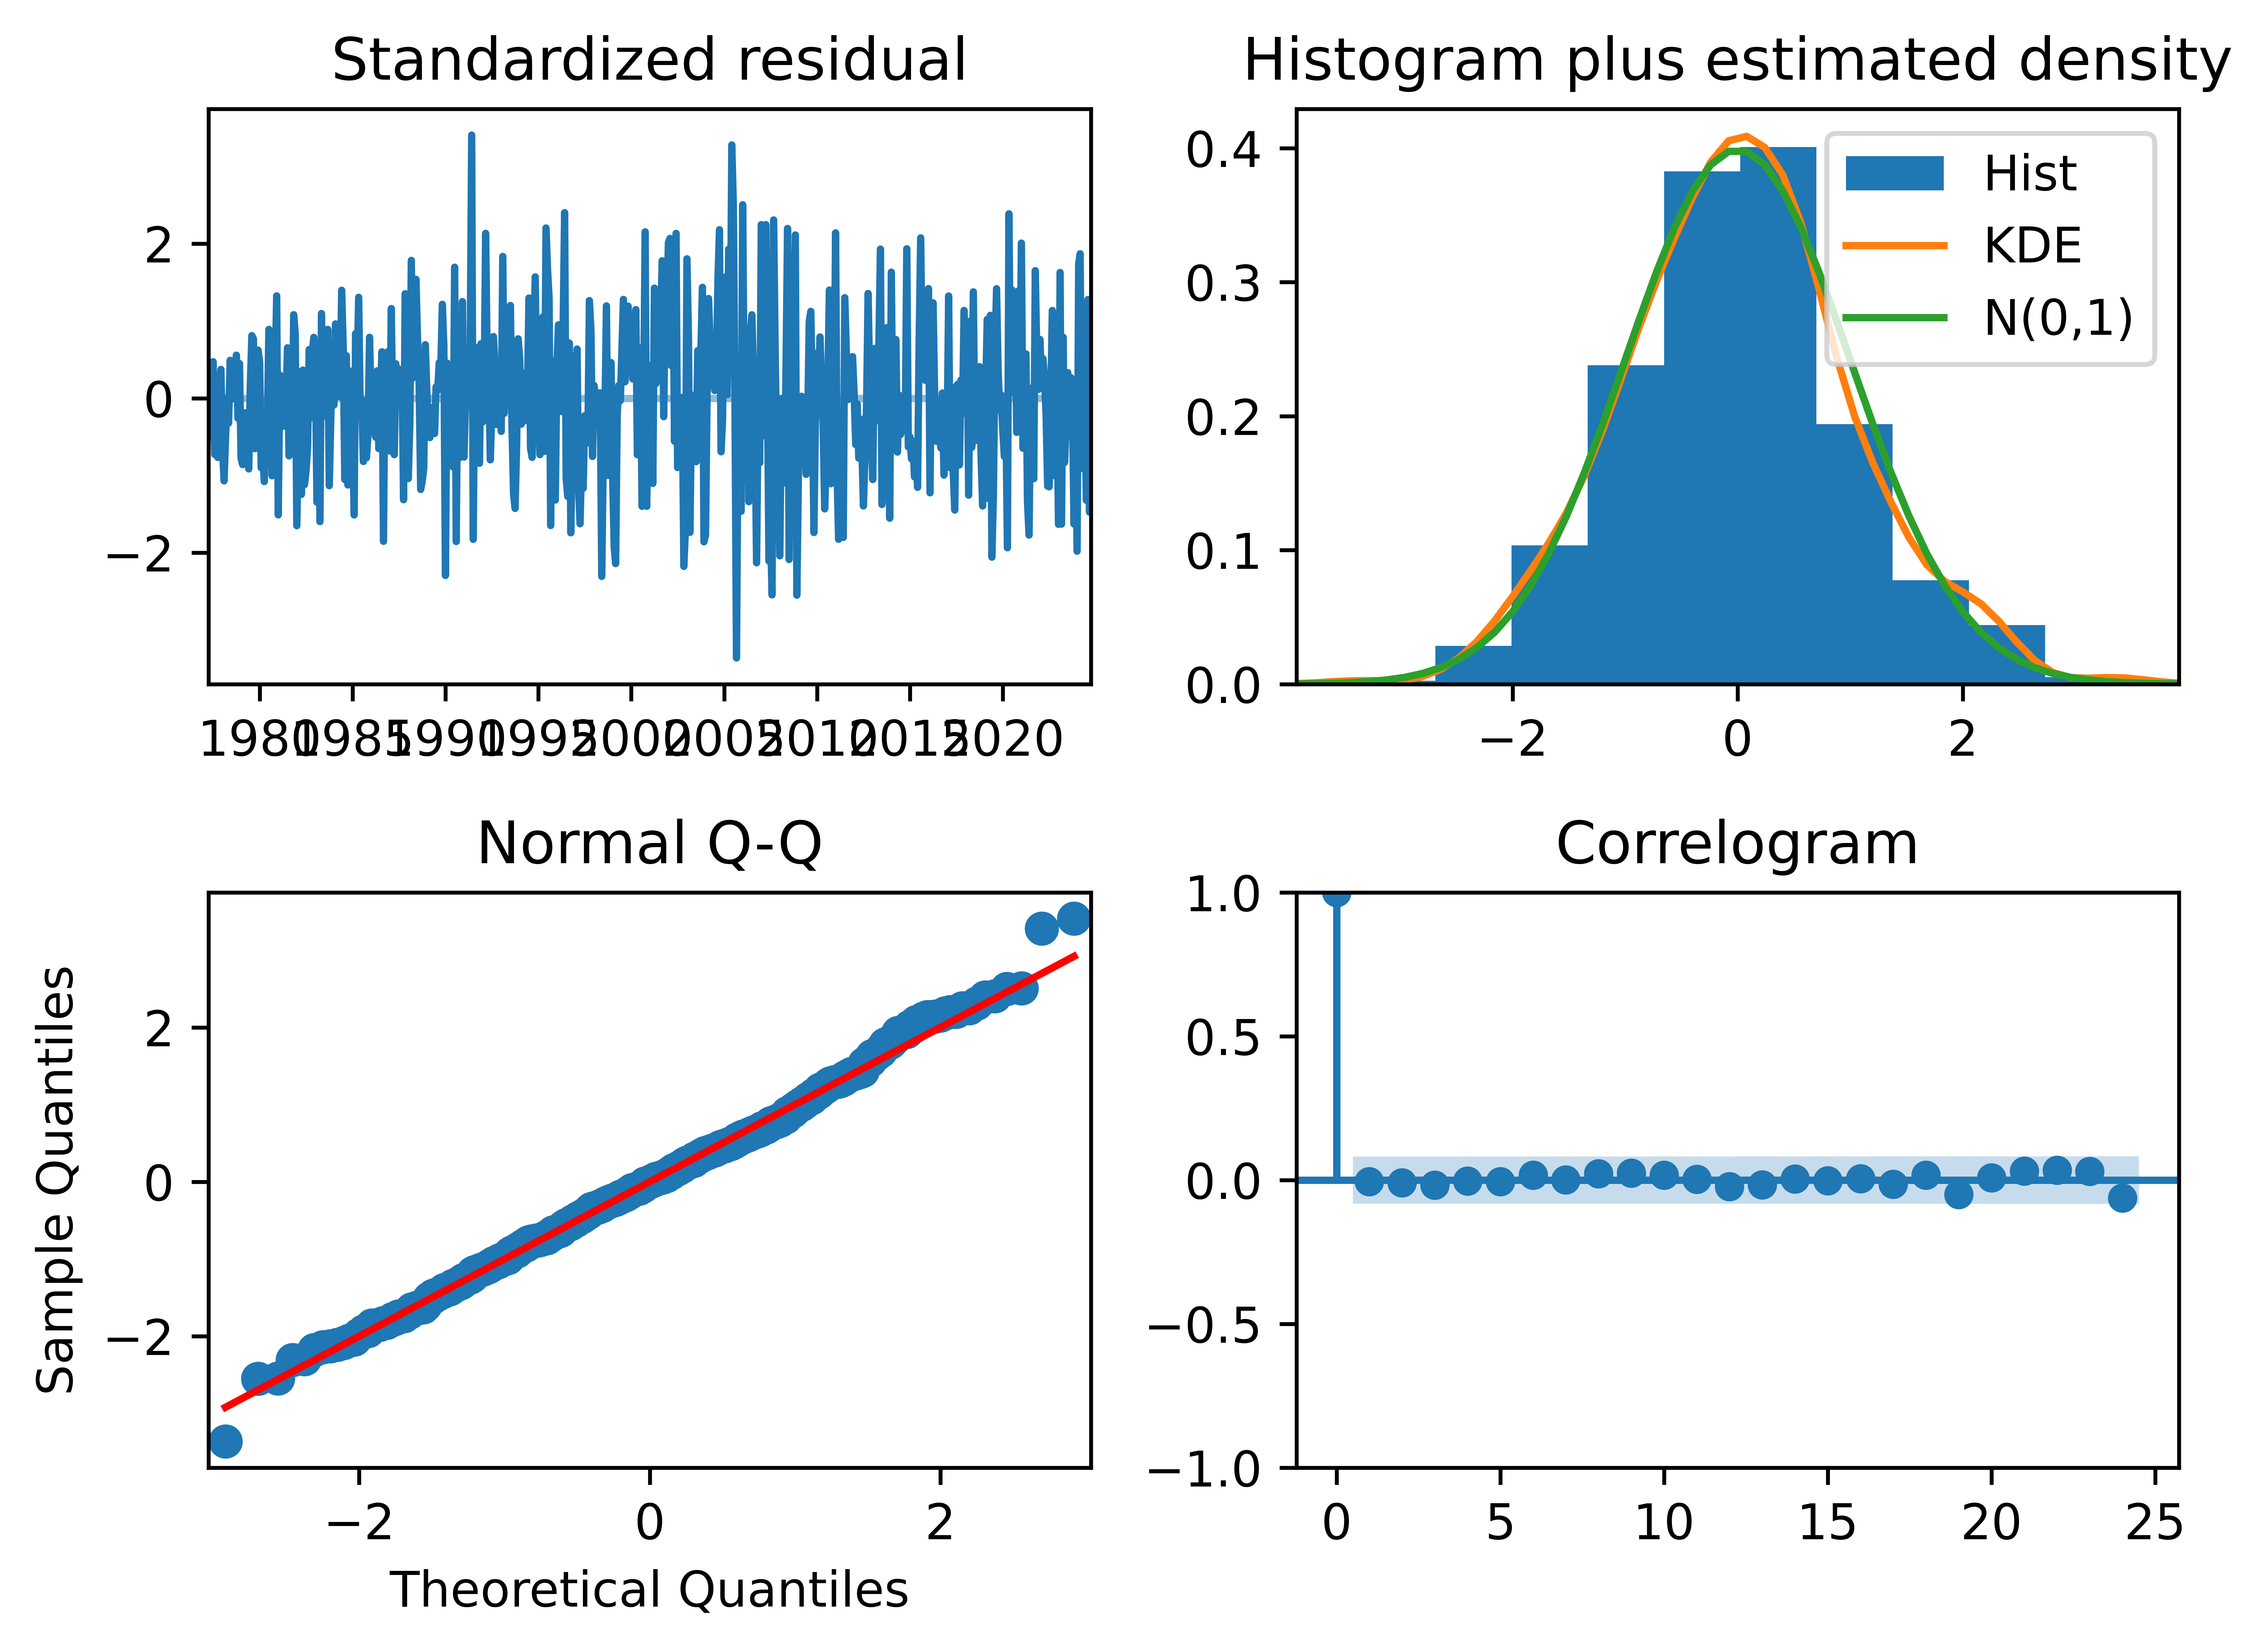

In [16]:
fig_diag = results_selected_model.plot_diagnostics(lags=24)
plt.tight_layout()
plt.show()

# AR(3) Forecast (No Seasonality)

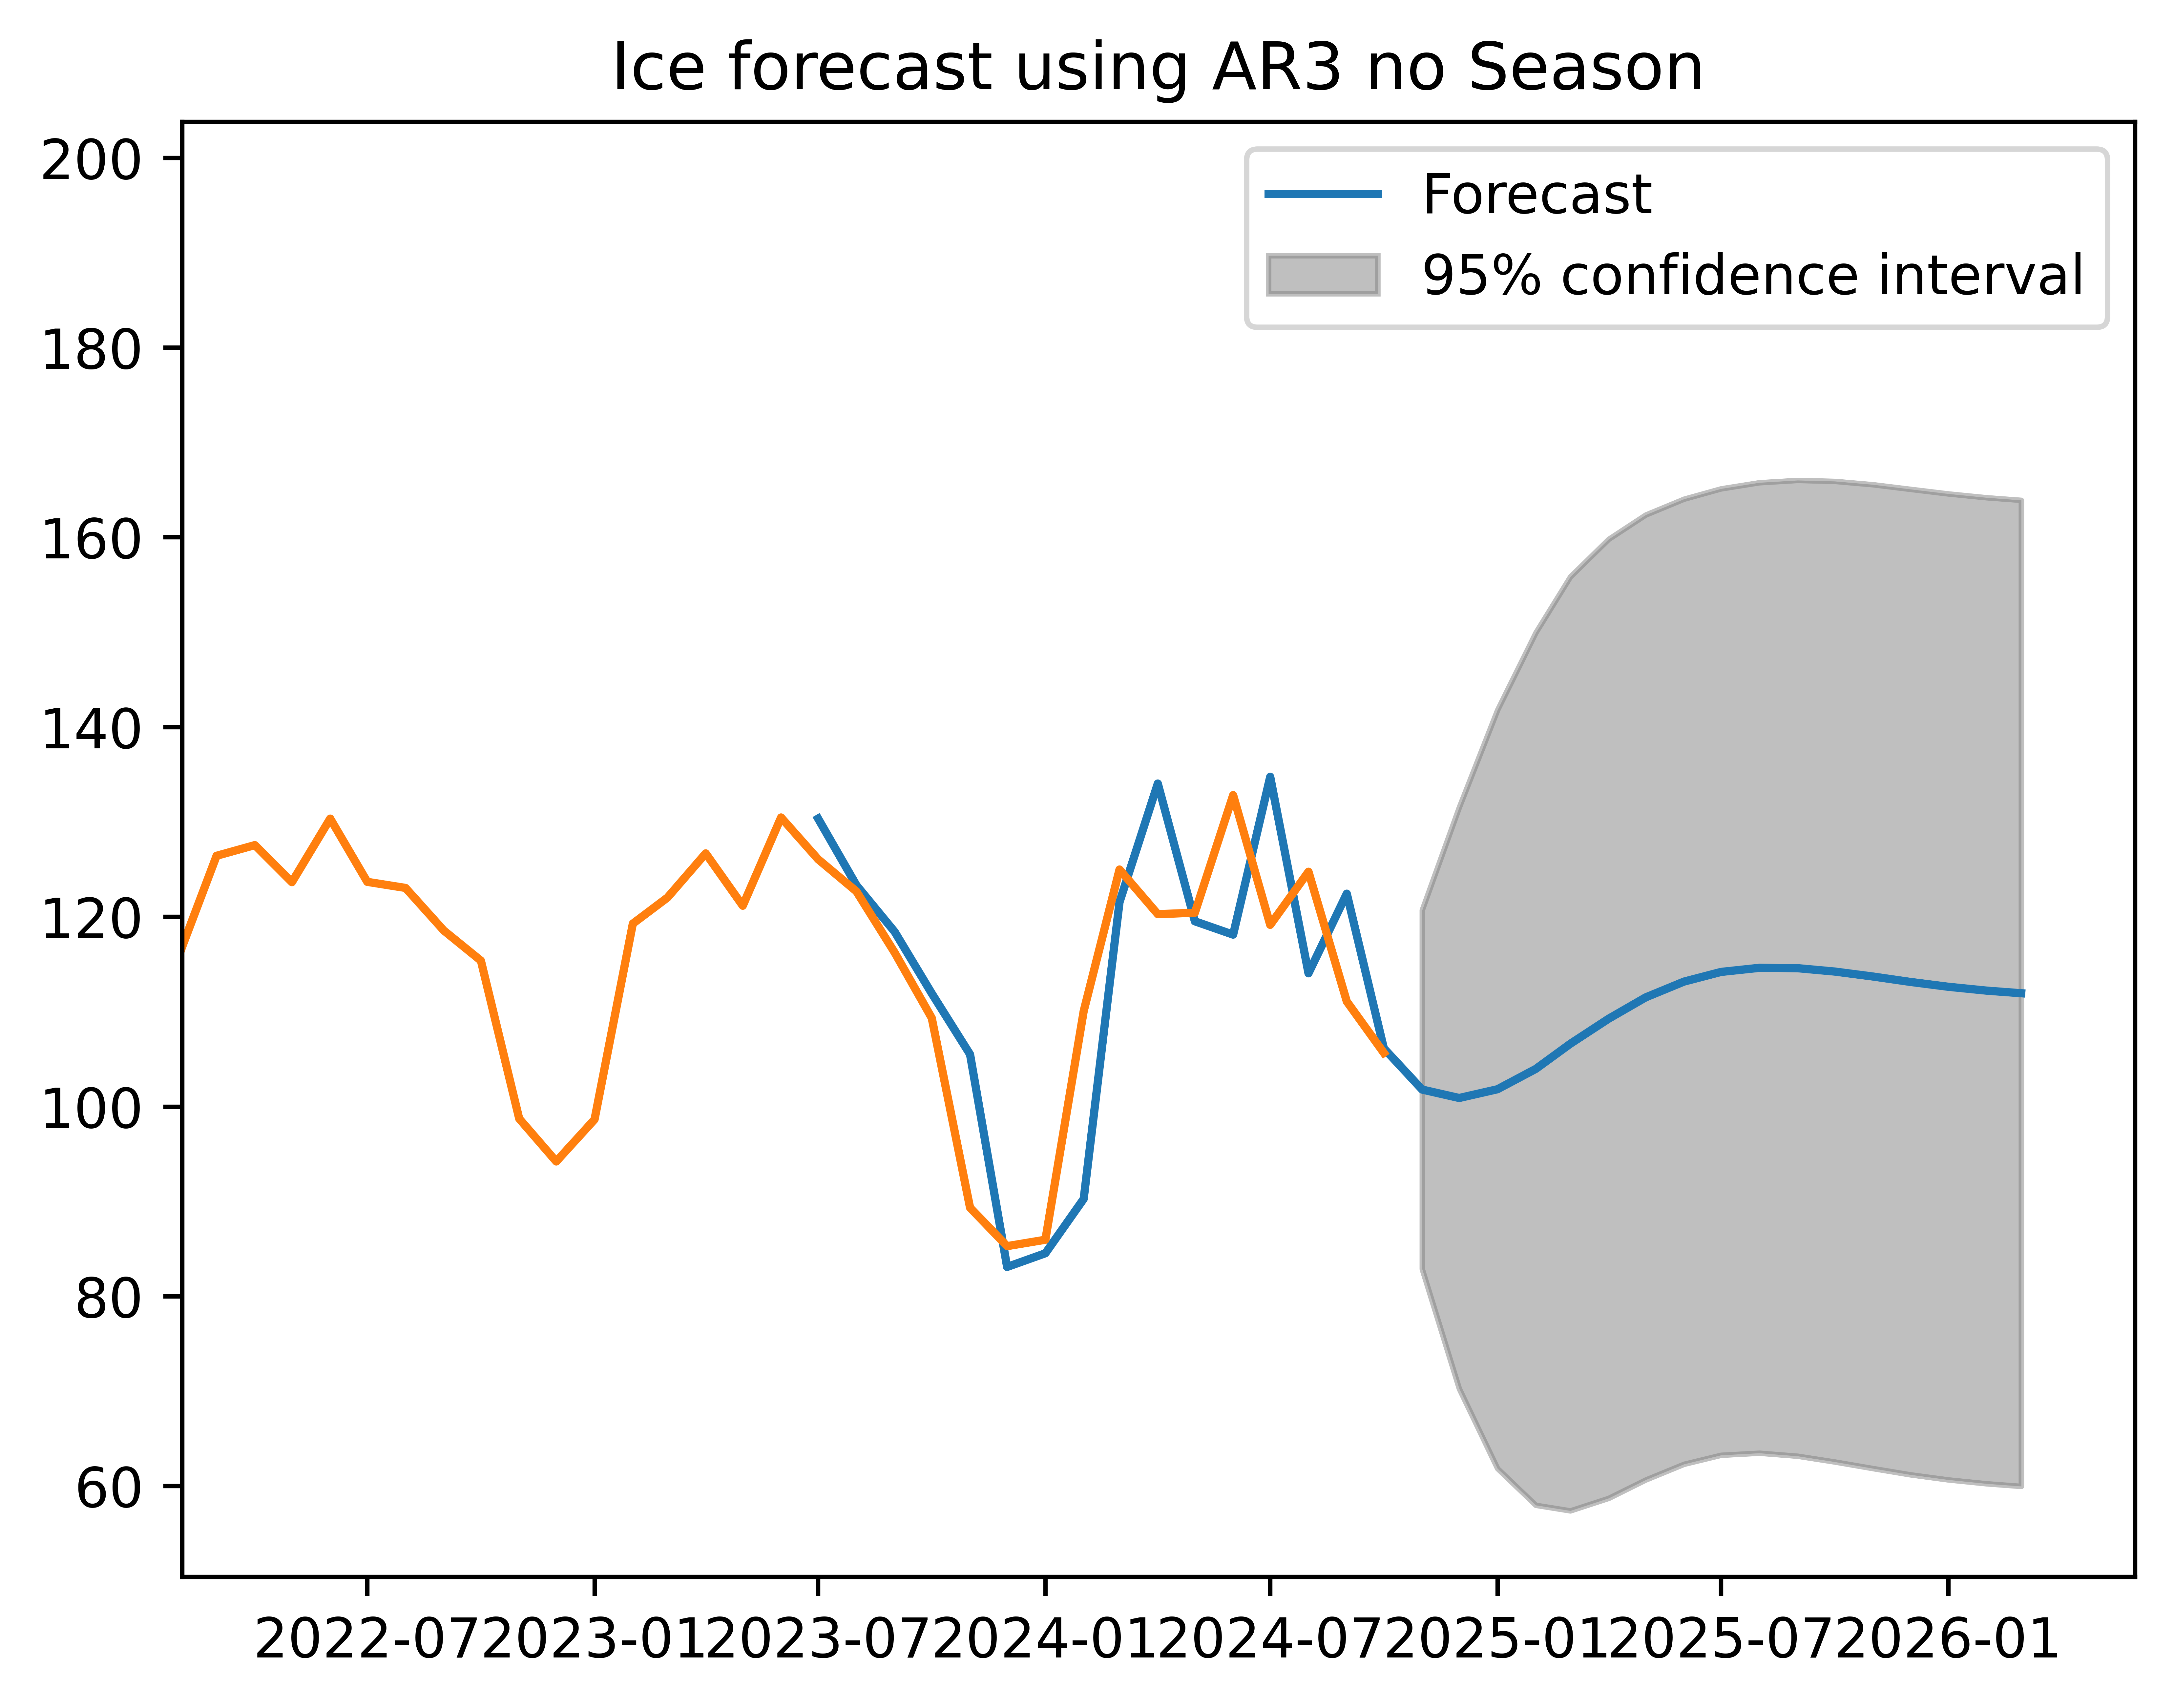

In [17]:
import datetime
resul_AR3.plot_predict(T-16, T+16, dynamic=False) #shows in-sample + out-of-sample predictions
plt.gca().set_title('Ice forecast using AR3 no Season')
plt.plot(data.index, dep, label='Observed IP of ice')
plt.gca().set_xbound(datetime.date(2022,2,1), datetime.date(2026,6,1))
plt.show()


# Forecast with the Selected Model

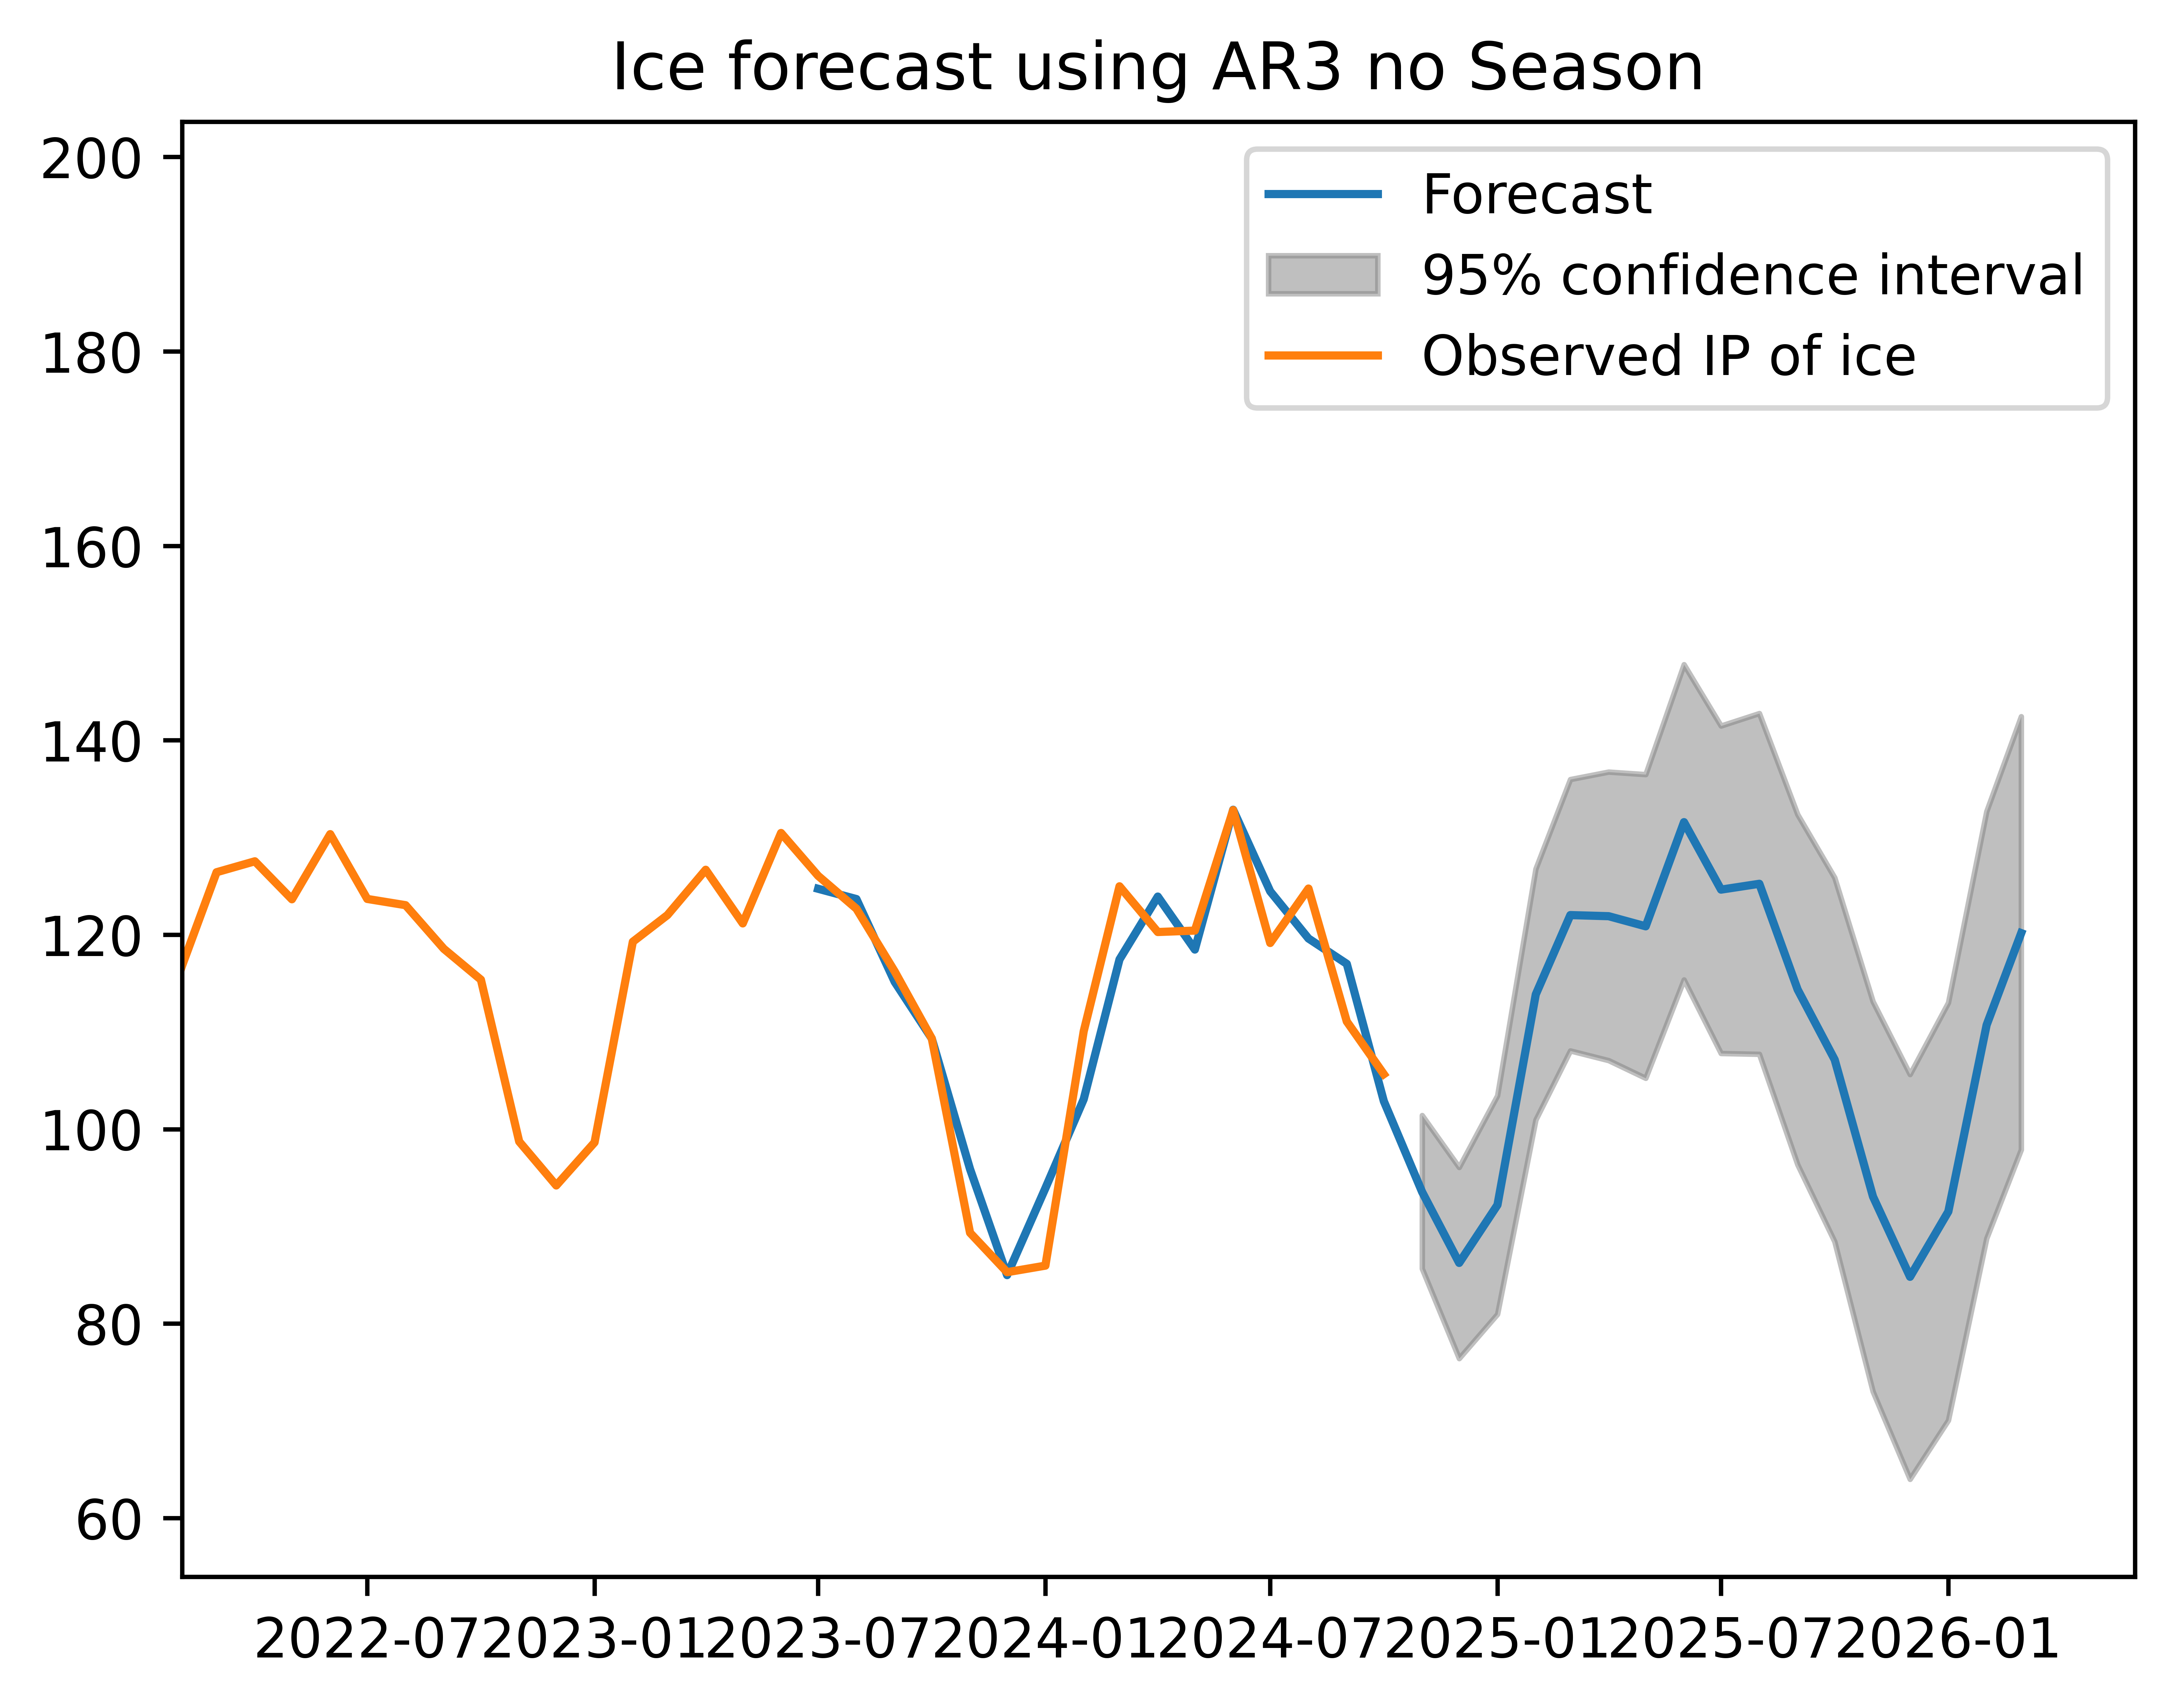

In [18]:
#Forecast with the Selected Model
results_selected_model.plot_predict(T-16, T+16, dynamic=False)
plt.gca().set_title('Ice forecast using AR3 no Season')
plt.plot(data.index, dep, label='Observed IP of ice')
plt.gca().set_xbound(datetime.date(2022,2,1), datetime.date(2026,6,1))
plt.legend()
plt.show()

# Compute RMSFE (Root Mean Squared Forecast Error)

$$
\text{RMSFE} = \sqrt{\frac{1}{n} \sum_{t=1}^n \left( y_t - \hat{y}_t \right)^2 }
$$


In [19]:
L = 90 # 15% of the sample

Predict_AR3 = resul_AR3.predict(T-L, T+L, dynamic=False)
predict_selected_model = results_selected_model.predict(T-L, T+L, dynamic=False)

rmsfe = lambda a, b: np.sqrt(np.mean((a.sub(b))**2))

print('RMSFE for AR3 without seasons is:')
print(rmsfe(data['ice'], Predict_AR3))

print('RMSFE for selected model is:')
print(rmsfe(data['ice'], predict_selected_model))

RMSFE for AR3 without seasons is:
8.529917794947618
RMSFE for selected model is:
4.104537643457874
